# Regressor for both syllables

First import some general libraries

In [1]:
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneOut, GridSearchCV
import scipy.io
import os
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor

In [2]:
path_code = os.getcwd()
Syllables_dataset = scipy.io.loadmat(os.path.join(path_code, "../Data/syllables_regr.mat"))
ar_m_pa = Syllables_dataset["ar_pa"]
af_m_pa = Syllables_dataset["af_pa"]
ar_m_ptk = Syllables_dataset["ar_ptk"]
af_m_ptk = Syllables_dataset["af_ptk"]
y_m = Syllables_dataset["slp"]

In [3]:
ar_pa = np.zeros([len(ar_m_pa[0]), 1])
for i in range(len(ar_m_pa[0])):
    ar_pa[i,0] = ar_m_pa[0][i][0][0]

af_pa = np.zeros([len(af_m_pa[0]), 1])
for i in range(len(af_m_pa[0])):
        af_pa[i,0] = af_m_pa[0][i][0][0]

ar_ptk = np.zeros([len(ar_m_ptk[0]), 1])
for i in range(len(ar_m_ptk[0])):
    ar_ptk[i,0] = ar_m_ptk[0][i][0][0]

af_ptk = np.zeros([len(af_m_ptk[0]), 1])
for i in range(len(af_m_ptk[0])):
        af_ptk[i,0] = af_m_ptk[0][i][0][0]

y = np.zeros([len(y_m[0]), 1])
for i in range(len(y_m[0])):
        y[i,0] = y_m[0][i][0][0]

y = y.ravel()

X = np.stack((ar_pa, af_pa, ar_ptk, af_ptk), axis=-1)
X = X.reshape(19, -1)

# SVR

***Linear kernel***

{'C': 0.5, 'epsilon': 0.5}

{'C': 5, 'epsilon': 0.5}

{'C': 10, 'epsilon': 0.01}

{'C': 10, 'epsilon': 0.01}

{'C': 0.5, 'epsilon': 1}

{'C': 10, 'epsilon': 0.01}

{'C': 5, 'epsilon': 0.01}

{'C': 0.5, 'epsilon': 1}

{'C': 10, 'epsilon': 0.01}

{'C': 5, 'epsilon': 0.5}

{'C': 10, 'epsilon': 0.01}

{'C': 0.5, 'epsilon': 1}

{'C': 10, 'epsilon': 1}

{'C': 5, 'epsilon': 1}

{'C': 0.5, 'epsilon': 0.5}

{'C': 0.5, 'epsilon': 0.5}

{'C': 5, 'epsilon': 0.5}

{'C': 10, 'epsilon': 0.01}

{'C': 15, 'epsilon': 0.01}

Nested LOOCV RMSE: 1.00


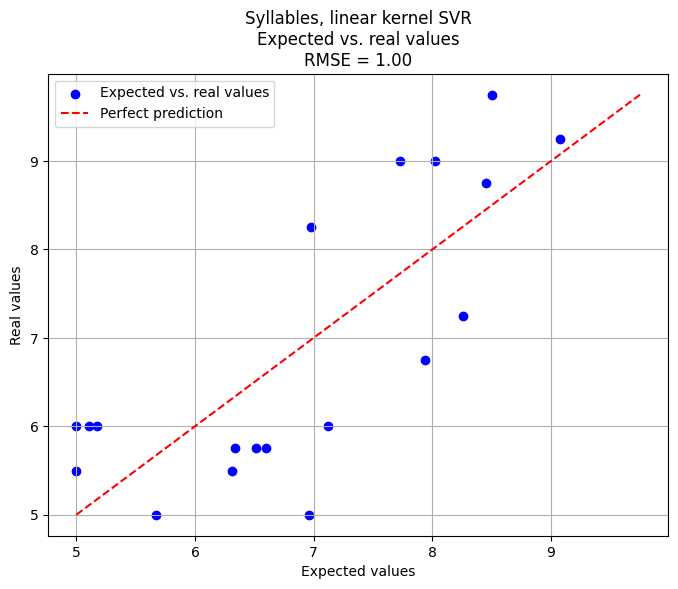

In [4]:
loo=LeaveOneOut()
y_true = []
y_pred = []
model = SVR(kernel='linear')
param_grid = {
    'C': [0.1, 0.5, 5, 10, 15],
    'epsilon': [0.01, 0.1, 0.5, 1]
}
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modello SVR
    svr = SVR(kernel='linear')

    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_loo, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = grid_search.best_params_
    best_svr = grid_search.best_estimator_
    print(f'{best_params}\n')

    # Fit del modello con i migliori parametri sul training set esterno e predizione
    best_svr.fit(X_train, y_train)
    y_pred.append(np.clip(best_svr.predict(X_test), 5, 25)[0])
    y_true.append(y_test[0])


y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_p, y_t, color='blue', label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='red', linestyle='--', label='Perfect prediction')


plt.xlabel('Expected values')
plt.ylabel('Real values')
plt.title('Syllables, linear kernel SVR\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend()

plt.grid(True)
plt.show()

***Sigmoidal kernel***

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0

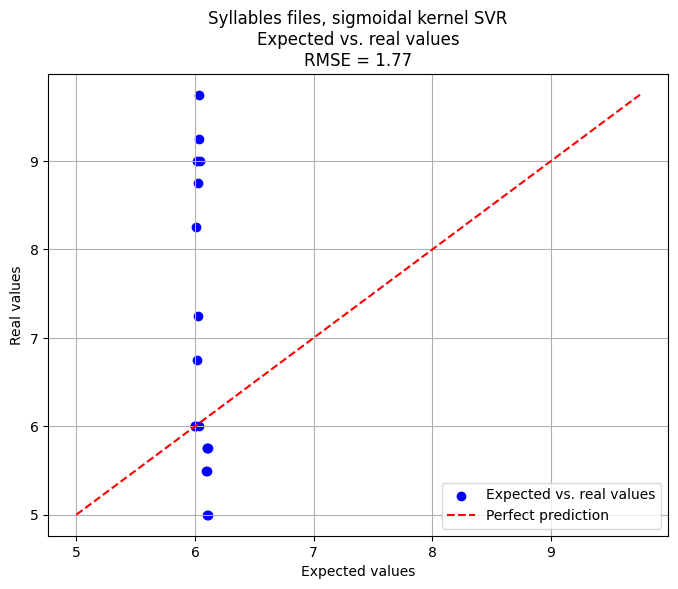

In [5]:
loo=LeaveOneOut()
y_true = []
y_pred = []

param_grid = {
    'C': [0.001, 0.01, 0.1],
    'gamma': [0.01, 0.1, 0.5, 1],
    'epsilon': [0.01, 0.05, 0.1],
    'coef0': [0.0, 0.1, 0.5]
}

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modello SVR
    svr = SVR(kernel='sigmoid')

    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_loo, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = grid_search.best_params_
    best_svr = grid_search.best_estimator_
    print(f'{best_params}\n')

    # Fit del modello con i migliori parametri sul training set esterno e predizione
    best_svr.fit(X_train, y_train)
    y_pred.append(np.clip(best_svr.predict(X_test), 5, 25)[0])
    y_true.append(y_test[0])


y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')
plt.figure(figsize=(8, 6))
plt.scatter(y_p, y_t, color='blue', label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='red', linestyle='--', label='Perfect prediction')


plt.xlabel('Expected values')
plt.ylabel('Real values')
plt.title('Syllables files, sigmoidal kernel SVR\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend()

plt.grid(True)
plt.show()

***RBF kernel***

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.5}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.05, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.05, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01

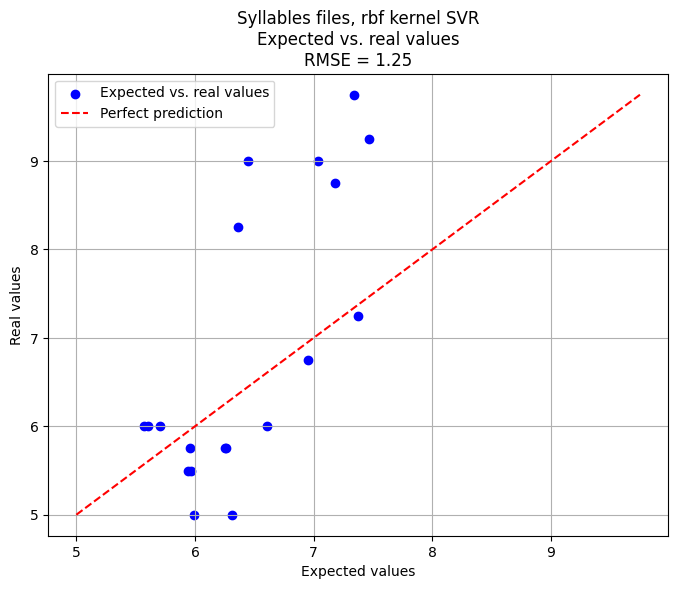

In [6]:
loo=LeaveOneOut()
y_true = []
y_pred = []

param_grid = {
    'C': [0.001, 0.01, 0.1, 0.2, 0.5],
    'gamma': [0.01, 0.1, 0.5, 1],
    'epsilon': [0.01, 0.05, 0.1],
    'coef0': [0.0, 0.1, 0.5]
}

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modello SVR
    svr = SVR(kernel='rbf')

    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_loo, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = grid_search.best_params_
    best_svr = grid_search.best_estimator_
    print(f'{best_params}\n')

    # Fit del modello con i migliori parametri sul training set esterno e predizione
    best_svr.fit(X_train, y_train)
    y_pred.append(np.clip(best_svr.predict(X_test), 5, 25)[0])
    y_true.append(y_test[0])


y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')
plt.figure(figsize=(8, 6))
plt.scatter(y_p, y_t, color='blue', label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='red', linestyle='--', label='Perfect prediction')


plt.xlabel('Expected values')
plt.ylabel('Real values')
plt.title('Syllables files, rbf kernel SVR\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend()

plt.grid(True)
plt.show()

# NN

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

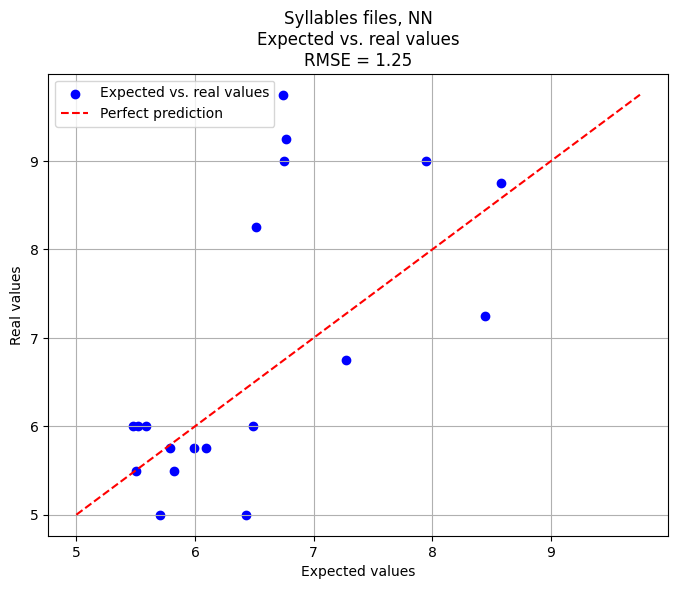

In [7]:
nn = MLPRegressor(
    activation='logistic',
    hidden_layer_sizes=(10, 100, 200),
    alpha=0.001,
    random_state=20,
    early_stopping=False,
    solver='adam',
    max_iter= 2000
)
param_grid = {
    'hidden_layer_sizes': [ (10, 30, 100), (10, 50, 100), (10, 50, 200), (10, 100, 100)], 
    'alpha': [0.0001, 0.001, 0.01],
}

# Creare oggetto LOOCV
loo = LeaveOneOut()
y_pred = []
y_true = []

# Loop su ogni iterazione di LOOCV
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_grid = GridSearchCV(estimator=nn, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', error_score='raise')
    inner_grid.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = inner_grid.best_params_
    best_model = inner_grid.best_estimator_
    print(f"{best_params}\n")
    # Fit del modello con i migliori parametri sul training set esterno
    best_model.fit(X_train, y_train)

    # Previsioni sul set di test corrente
    y_pred.extend(np.clip(best_model.predict(X_test), 5,25))
    y_true.extend(y_test)

y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')
plt.figure(figsize=(8, 6))
plt.scatter(y_p, y_t, color='blue', label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='red', linestyle='--', label='Perfect prediction')


plt.xlabel('Expected values')
plt.ylabel('Real values')
plt.title('Syllables files, NN\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend()

plt.grid(True)
plt.show()

# Thresholded files

In [8]:
Syllables_dataset = scipy.io.loadmat(os.path.join(path_code, "../Data/syllables_th_regr.mat"))
ar_m_pa = Syllables_dataset["ar_th_pa"]
af_m_pa = Syllables_dataset["af_th_pa"]
ar_m_ptk = Syllables_dataset["ar_th_ptk"]
af_m_ptk = Syllables_dataset["af_th_ptk"]
y_m = Syllables_dataset["slp"]

In [9]:
ar_pa = np.zeros([len(ar_m_pa[0]), 1])
for i in range(len(ar_m_pa[0])):
    ar_pa[i,0] = ar_m_pa[0][i][0][0]

af_pa = np.zeros([len(af_m_pa[0]), 1])
for i in range(len(af_m_pa[0])):
        af_pa[i,0] = af_m_pa[0][i][0][0]

ar_ptk = np.zeros([len(ar_m_ptk[0]), 1])
for i in range(len(ar_m_ptk[0])):
    ar_ptk[i,0] = ar_m_ptk[0][i][0][0]

af_ptk = np.zeros([len(af_m_ptk[0]), 1])
for i in range(len(af_m_ptk[0])):
        af_ptk[i,0] = af_m_ptk[0][i][0][0]

y = np.zeros([len(y_m[0]), 1])
for i in range(len(y_m[0])):
        y[i,0] = y_m[0][i][0][0]

y = y.ravel()

X = np.stack((ar_pa, af_pa, ar_ptk, af_ptk), axis=-1)
X = X.reshape(19, -1)

# SVR

***Linear kernel***

{'C': 5, 'epsilon': 0.01}

{'C': 15, 'epsilon': 0.5}

{'C': 5, 'epsilon': 0.01}

{'C': 15, 'epsilon': 1}

{'C': 5, 'epsilon': 0.01}

{'C': 5, 'epsilon': 0.01}

{'C': 10, 'epsilon': 1}

{'C': 5, 'epsilon': 0.01}

{'C': 10, 'epsilon': 1}

{'C': 5, 'epsilon': 0.01}

{'C': 5, 'epsilon': 0.01}

{'C': 15, 'epsilon': 0.1}

{'C': 10, 'epsilon': 0.5}

{'C': 5, 'epsilon': 0.01}

{'C': 5, 'epsilon': 0.01}

{'C': 15, 'epsilon': 1}

{'C': 5, 'epsilon': 0.01}

{'C': 5, 'epsilon': 0.01}

{'C': 5, 'epsilon': 0.01}

Nested LOOCV RMSE: 1.12


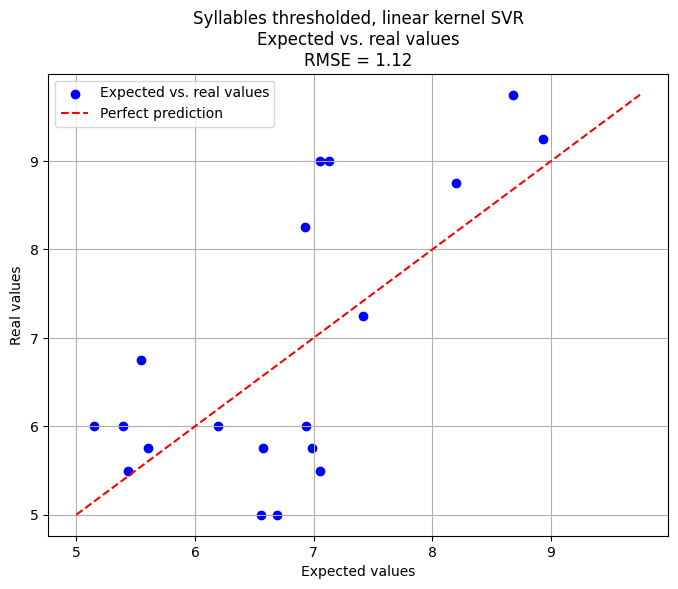

In [10]:
loo=LeaveOneOut()
y_true = []
y_pred = []
model = SVR(kernel='linear')
param_grid = {
    'C': [0.1, 0.5, 5, 10, 15],
    'epsilon': [0.01, 0.1, 0.5, 1]
}
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modello SVR
    svr = SVR(kernel='linear')

    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_loo, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = grid_search.best_params_
    best_svr = grid_search.best_estimator_
    print(f'{best_params}\n')

    # Fit del modello con i migliori parametri sul training set esterno e predizione
    best_svr.fit(X_train, y_train)
    y_pred.append(np.clip(best_svr.predict(X_test), 5, 25)[0])
    y_true.append(y_test[0])


y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_p, y_t, color='blue', label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='red', linestyle='--', label='Perfect prediction')


plt.xlabel('Expected values')
plt.ylabel('Real values')
plt.title('Syllables thresholded, linear kernel SVR\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend()

plt.grid(True)
plt.show()

***Sigmoidal kernel***

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.01}

{'C': 0.1, 'coef0': 0

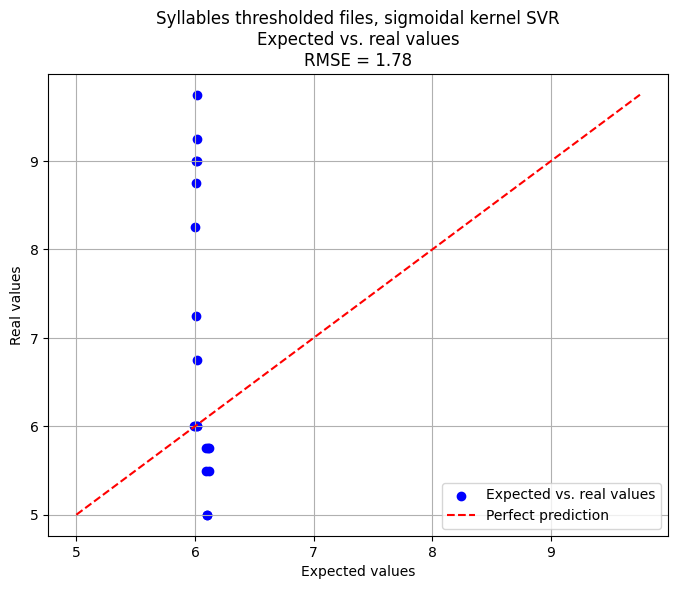

In [11]:
loo=LeaveOneOut()
y_true = []
y_pred = []

param_grid = {
    'C': [0.001, 0.01, 0.1],
    'gamma': [0.01, 0.1, 0.5, 1],
    'epsilon': [0.01, 0.05, 0.1],
    'coef0': [0.0, 0.1, 0.5]
}

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modello SVR
    svr = SVR(kernel='sigmoid')

    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_loo, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = grid_search.best_params_
    best_svr = grid_search.best_estimator_
    print(f'{best_params}\n')

    # Fit del modello con i migliori parametri sul training set esterno e predizione
    best_svr.fit(X_train, y_train)
    y_pred.append(np.clip(best_svr.predict(X_test), 5, 25)[0])
    y_true.append(y_test[0])


y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')
plt.figure(figsize=(8, 6))
plt.scatter(y_p, y_t, color='blue', label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='red', linestyle='--', label='Perfect prediction')


plt.xlabel('Expected values')
plt.ylabel('Real values')
plt.title('Syllables thresholded files, sigmoidal kernel SVR\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend()

plt.grid(True)
plt.show()

***RBF kernel***

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.5}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.2, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.1}

{'C': 0.5, 'coef0': 0.0, 'epsilon': 0.1

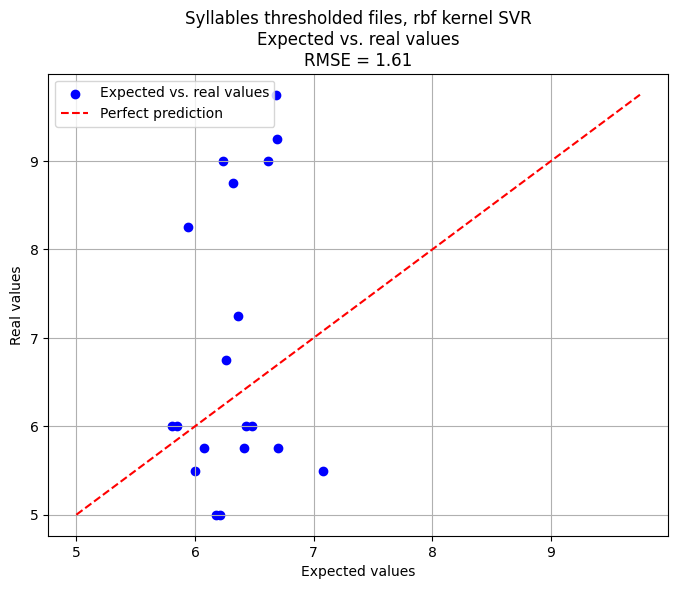

In [12]:
loo=LeaveOneOut()
y_true = []
y_pred = []

param_grid = {
    'C': [0.001, 0.01, 0.1, 0.2, 0.5],
    'gamma': [0.01, 0.1, 0.5, 1],
    'epsilon': [0.01, 0.05, 0.1],
    'coef0': [0.0, 0.1, 0.5]
}

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modello SVR
    svr = SVR(kernel='rbf')

    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_loo, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = grid_search.best_params_
    best_svr = grid_search.best_estimator_
    print(f'{best_params}\n')

    # Fit del modello con i migliori parametri sul training set esterno e predizione
    best_svr.fit(X_train, y_train)
    y_pred.append(np.clip(best_svr.predict(X_test), 5, 25)[0])
    y_true.append(y_test[0])


y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')
plt.figure(figsize=(8, 6))
plt.scatter(y_p, y_t, color='blue', label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='red', linestyle='--', label='Perfect prediction')


plt.xlabel('Expected values')
plt.ylabel('Real values')
plt.title('Syllables thresholded files, rbf kernel SVR\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend()

plt.grid(True)
plt.show()

# NN

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}



c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}



c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}



c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}



c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warning

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}



c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warning

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}



c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warning

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}



c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warning

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}



c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\SLARegressor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warning

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

Nested LOOCV RMSE: 1.68


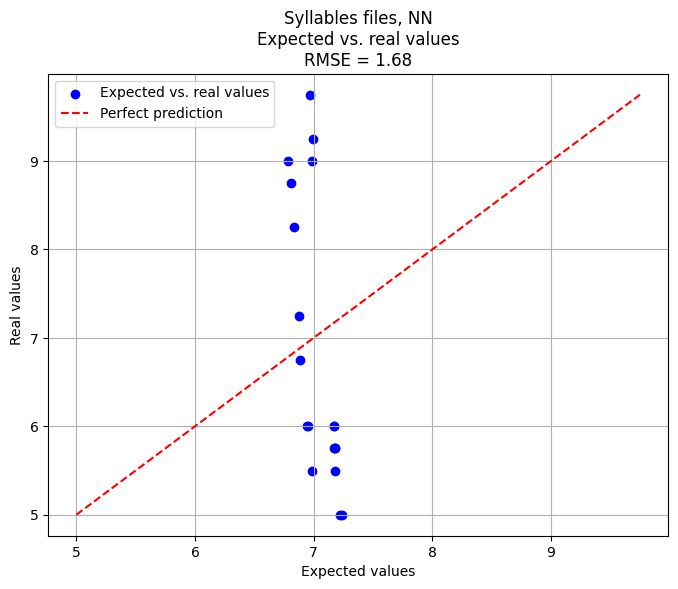

In [13]:
nn = MLPRegressor(
    activation='logistic',
    hidden_layer_sizes=(10, 100, 200),
    alpha=0.001,
    random_state=20,
    early_stopping=False,
    solver='adam',
    max_iter= 2000
)
param_grid = {
    'hidden_layer_sizes': [ (10, 30, 100), (10, 50, 100), (10, 50, 200), (10, 100, 100)], 
    'alpha': [0.0001, 0.001, 0.01],
}

# Creare oggetto LOOCV
loo = LeaveOneOut()
y_pred = []
y_true = []

# Loop su ogni iterazione di LOOCV
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_grid = GridSearchCV(estimator=nn, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', error_score='raise')
    inner_grid.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = inner_grid.best_params_
    best_model = inner_grid.best_estimator_
    print(f"{best_params}\n")
    # Fit del modello con i migliori parametri sul training set esterno
    best_model.fit(X_train, y_train)

    # Previsioni sul set di test corrente
    y_pred.extend(np.clip(best_model.predict(X_test), 5,25))
    y_true.extend(y_test)

y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')
plt.figure(figsize=(8, 6))
plt.scatter(y_p, y_t, color='blue', label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='red', linestyle='--', label='Perfect prediction')


plt.xlabel('Expected values')
plt.ylabel('Real values')
plt.title('Syllables files, NN\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend()

plt.grid(True)
plt.show()